# Spotify Clustering

## Data Preprocessing

First we import all needed modules and functions:

In [20]:
from spotify_clustering import load_data, preprocess_data, scale_data, silhouette_scores, determine_candidate_target_attribute,get_target, bin_target, kmeans_clustering, cluster_f1, cluster_confusion_matrix, get_cluster_class_mapping, perform_pca, plot_clusters, cluster_properties_report, print_cluster_properties
from tree_cluster_rules_retrieval import cluster_properties_report
%matplotlib notebook


With the following cell the data is loaded and the first 5 rows are displayed:


In [21]:
df=load_data().reset_index(drop=True)
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade,hit
0,Redshift,Soul Extract,spotify:track:6zqI70p7pulTXdha8A3GcR,0.531,0.876,4,-6.381,0,0.0948,0.000313,0.000000,0.0809,0.306,148.026,248010,4,19.92028,10,10s,0
1,Mini-Skirt Minnie,Wilson Pickett,spotify:track:7p7kHvFpphFrlZvgKUhclw,0.680,0.648,9,-9.482,1,0.0749,0.193000,0.000124,0.0419,0.827,97.700,179200,4,33.01747,8,60s,1
2,Airship,Nobuo Uematsu,spotify:track:3Dh0ceEo8pIuzS7xTCm8KW,0.282,0.337,10,-13.761,1,0.0457,0.598000,0.853000,0.1700,0.945,180.508,49933,4,21.10148,5,80s,0
3,Don't Walk Away,Toni Childs,spotify:track:4R9rKeBJjQSMiKIXacPPEI,0.660,0.814,11,-10.808,1,0.0345,0.065000,0.000012,0.1190,0.722,115.134,238973,4,29.60502,12,80s,1
4,Post To Be,Omarion Featuring Chris Brown & Jhene Aiko,spotify:track:0fgZUSa7D7aVvv3GfO0A1n,0.733,0.676,10,-5.655,0,0.0432,0.069700,0.000000,0.2080,0.701,97.448,226581,4,18.36223,13,10s,1


The association rule mining already proved that some attribute do not hold great predictive value. Therefore, the attributes `track` `artist` and `uri` are dropped. `decade` contains alphanumeric values so it is transformed into a pure numeric format:

In [22]:
df=preprocess_data(df)
df_scaled=scale_data(df)
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade,hit
0,0.531,0.876,4,-6.381,0,0.0948,0.000313,0.000000,0.0809,0.306,148.026,248010,4,19.92028,10,2010,0
1,0.680,0.648,9,-9.482,1,0.0749,0.193000,0.000124,0.0419,0.827,97.700,179200,4,33.01747,8,1960,1
2,0.282,0.337,10,-13.761,1,0.0457,0.598000,0.853000,0.1700,0.945,180.508,49933,4,21.10148,5,1980,0
3,0.660,0.814,11,-10.808,1,0.0345,0.065000,0.000012,0.1190,0.722,115.134,238973,4,29.60502,12,1980,1
4,0.733,0.676,10,-5.655,0,0.0432,0.069700,0.000000,0.2080,0.701,97.448,226581,4,18.36223,13,2010,1


## Cluster Experiment

With the above defined functions following experimental cluster analysis is conducted:

1. **Determination how many clusters describe the data best by calculation of silhouette coefficients using a KMeans.**
2. **Exploration of which attribute is a possible target class candidate by iteratively using each attribute of the data as target class and storing of the F1-score.**
3. **Further analyis of the run in 2. leading to the highest F1-score**
4. **Plotting of the samples in 3d space; firstly colored according to their true class of the best run in 2. and secondly to their belonging cluster predicted by the clustering algorithm.**
5. **Extraction of cluster properties by training a decision tree**

### 1. Calculation of the silhouette coefficients:

In [4]:
sc_max_kmeans, sc_kmeans=silhouette_scores(df_scaled, kmeans_clustering, n_clusters=(2,11))
print('Optimal amount of clusters: {}'.format(sc_max_kmeans))
print('Silhoutte coefficient: {}'.format(sc_kmeans))

Optimal amount of clusters: 2
Silhoutte coefficient: 0.165


### 2. Finding of possible target attribute:

The given silhouette coefficient is rather low and suggests that the data should be clustered in 2 groups. This information is respected for finding a candidate target attribute that represents could explain the clustering results:

In [24]:
target_attribute_kmeans,ser_clustering_scores=determine_candidate_target_attribute(df_scaled,sc_max_kmeans, kmeans_clustering)
print('Highest scoring attribute: {}'.format(target_attribute_kmeans))
print()
print('Attribute and its F1-score:')
print(ser_clustering_scores)

Highest scoring attribute: energy

Attribute and its F1-score:
danceability        0.646715
energy              0.740604
key                 0.517028
loudness            0.637146
mode                0.574117
speechiness         0.652567
acousticness        0.729045
instrumentalness    0.611887
liveness            0.640893
valence             0.611916
tempo               0.592220
duration_ms         0.654412
time_signature      0.618446
chorus_hit          0.648910
sections            0.654547
decade              0.517302
hit                 0.636459
Name: F1-scores, dtype: float64


### 3.  Further analyis of highest scoring target attribute

The target attribute `target_attribute_kmeans` is first used to produce a class labels mapping `dict_class_labels_kmeans` with the unscaled data for better interpretability in the data plotting and cluster property extraction:

In [25]:
_, target_unscaled_kmeans=get_target(df, target_attribute_kmeans)
_,dict_class_labels_kmeans=bin_target(target_unscaled_kmeans, n_bins=sc_max_kmeans)
df=df.drop(target_attribute_kmeans, axis='columns')

Consequently the clustering data is produced by splitting the target attribute from the scaled dataframe and binning it according to the optimal amount of clusters `sc_max_kmeans` resultin in the ` y_true_kmeans` variable.

In [26]:
df_scaled_kmeans, target_kmeans=get_target(df_scaled, target_attribute_kmeans)
y_true_kmeans,_=bin_target(target_kmeans, n_bins=sc_max_kmeans)

By utilizing the KMeans algorithm, the data `df_scaled` is clustered into `sc_max_kmeans=2` clusters and the predicted labels for the data samples `y_pred_kmeans` are produced. Additionally `dict_cluster_labels_kmeans` is produced containing a mapping for the cluster names.

In [27]:
y_pred_kmeans, kmeans=kmeans_clustering(df_scaled_kmeans,n_clusters=sc_max_kmeans)
dict_cluster_labels_kmeans={cluster:'cluster {}'.format(cluster) for cluster in set(list(y_pred_kmeans))}

Comparing the target attribute labels `y_true_kmeans` with the predicted labels `y_pred_kmeans` gives us the F1-score an confusion matrix for the clustering:

In [28]:
f1_kmeans=cluster_f1(y_true_kmeans, y_pred_kmeans, dict_class_labels_kmeans)
df_cm_kmeans=cluster_confusion_matrix(y_true_kmeans, y_pred_kmeans, dict_class_labels_kmeans)
print('F1-score {} for the using the attribute {} as target label'.format(f1_kmeans, target_attribute_kmeans))
print()
print('Confusion Matrix:')
print(df_cm_kmeans)

F1-score 0.7406035587410478 for the using the attribute energy as target label

Confusion Matrix:
                       cluster 0  cluster 1
energy (0.003, 0.501)        224        134
energy (0.501, 0.999)         99        543


### 4. Plotting of the data in 3d space

Visualization of the produced clusters gives a better overview of the results. Thus, `df_scaled` is transformed into 3 dimensional space using PCA. Finding relations between clusters and classes was achieved with the function `get_cluster_class_mapping` leading to a better comparable color mapping:

Class-cluster mapping:
energy (0.003, 0.501)    cluster 0
energy (0.501, 0.999)    cluster 1
dtype: object

Attribute-labeled scatter plot:


<IPython.core.display.Javascript object>


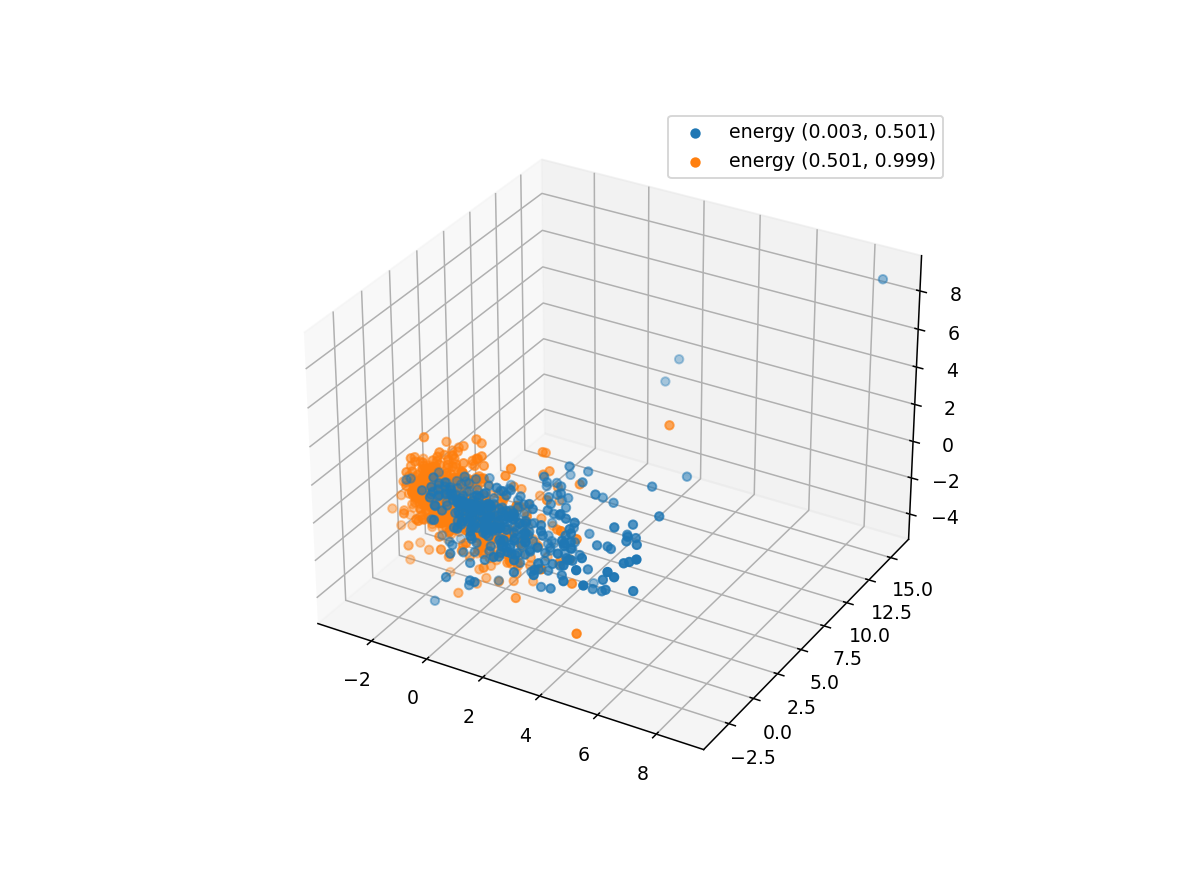


Cluster-labeled scatter plot:


<IPython.core.display.Javascript object>


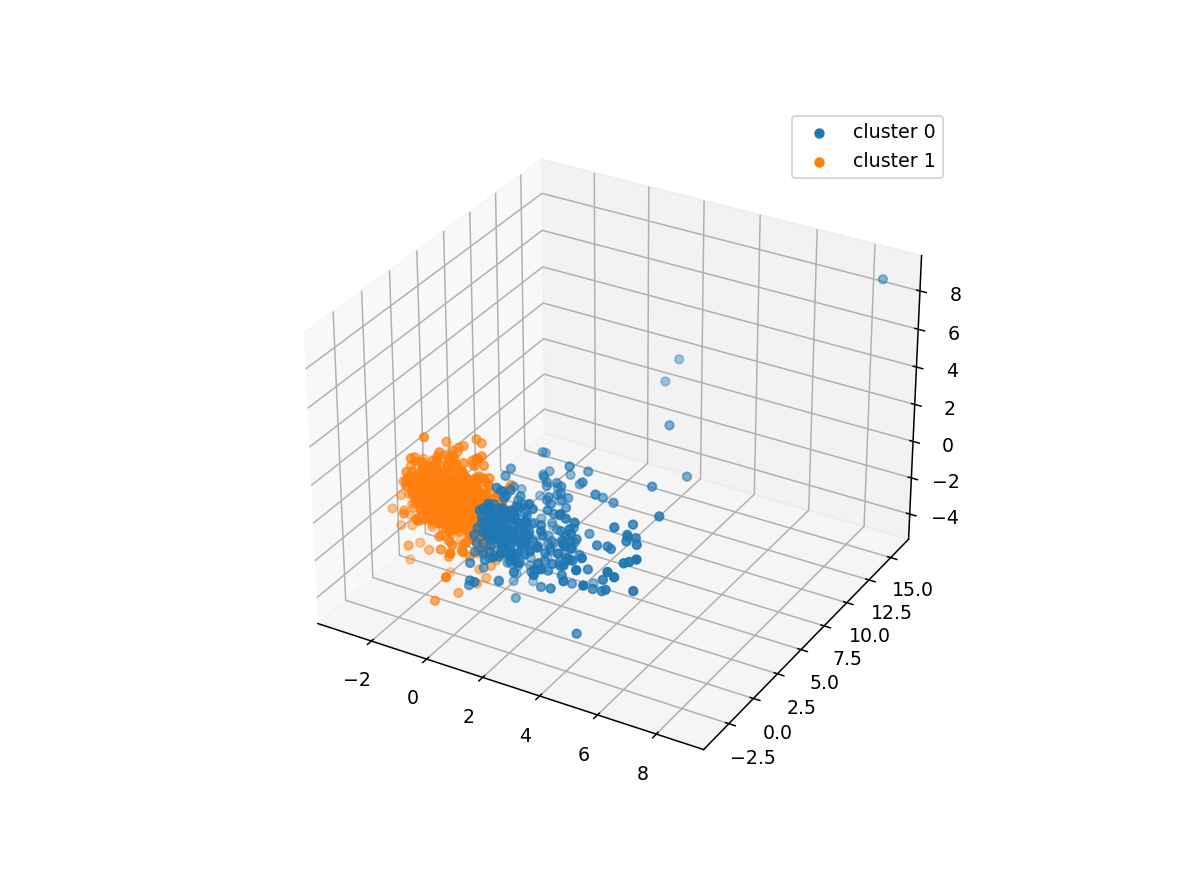

In [29]:
ser_mapping_kmeans=get_cluster_class_mapping(y_true_kmeans, y_pred_kmeans, dict_class_labels_kmeans)
print('Class-cluster mapping:')
print(ser_mapping_kmeans)
print()

df_pc_kmeans=perform_pca(df_scaled_kmeans)
print('Attribute-labeled scatter plot:')
plot_clusters(df_pc_kmeans, y_true_kmeans, dict_class_labels_kmeans, ser_mapping_kmeans,clustering=False)
print()
print('Cluster-labeled scatter plot:')
plot_clusters(df_pc_kmeans, y_pred_kmeans, dict_cluster_labels_kmeans, ser_mapping_kmeans,clustering=True)

### 5. Extraction of cluster properties

Having a clustered dataset arises the urge to find the common properties of a cluster. Training a decision tree on the data with cluster labels and extracting the splitting criterions gives insights on the common characteristics within a cluster how cluster differ from each other:

In [30]:
ser_stacked_cluster_rules_kmeans,ser_cluster_rules_kmeans= cluster_properties_report(df, y_pred_kmeans)
print_cluster_properties(ser_cluster_rules_kmeans)

    Characteristic rules for cluster 0:
        rule: (hit <= 0.5) applies for 259 out of 323 elements in cluster 0
        rule: (valence <= 0.648) applies for 236 out of 323 elements in cluster 0
        rule: (loudness <= -7.636) applies for 222 out of 323 elements in cluster 0
        rule: (acousticness > 0.754) applies for 27 out of 323 elements in cluster 0
        rule: (hit > 0.5) applies for 27 out of 323 elements in cluster 0
        rule: (valence <= 0.499) applies for 27 out of 323 elements in cluster 0
        rule: (instrumentalness > 0.296) applies for 23 out of 323 elements in cluster 0
        rule: (valence > 0.648) applies for 23 out of 323 elements in cluster 0
        rule: (instrumentalness > 0.413) applies for 14 out of 323 elements in cluster 0
        rule: (loudness > -7.636) applies for 14 out of 323 elements in cluster 0

    Characteristic rules for cluster 1:
        rule: (hit > 0.5) applies for 465 out of 677 elements in cluster 1
        rule: (acousti